In [1]:
import torch
import matplotlib.pyplot as plt

from torch.nn.functional import conv1d
from torch.nn.functional import pad

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'

## Discrete Convolutions

#### Define a 1d signal $u(t)$

In [2]:
L = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5
u = torch.sin(freq * x)

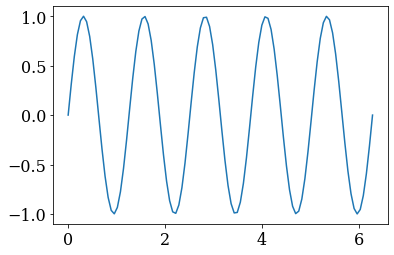

In [3]:
plt.plot(x, u)

##### Convolve it with $h(t)$

In [4]:
M = 30
x = torch.linspace(-2, 2, M) 
h = torch.exp(- x.pow(2))

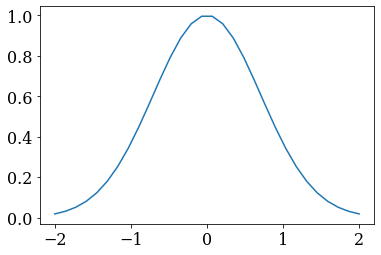

In [5]:
plt.plot(x, h)

In [6]:
def conv_naive(u, h):
    r"Performs a 1-dimensional convolution between u and h"
    L, M = u.shape[0], h.shape[0]
    y = torch.zeros(L + M - 1)
    # we pad u with zeros before and after the signal
    # so that the u[k - m] is defined even at u[0]
    # the - 1 stems from the fact that the convolution is starting
    # with the kernel already overlapping the signal at one entry:
    # imagine h sliding from the left to the right! This should be understood
    # at an intuitive level before continuing
    u_pad = torch.cat([torch.zeros(M-1), u, torch.zeros(M-1)]) 
    for k in range(M - 1, L + 2 * M - 2):
        for m in range(M):
            y[k - M  + 1] += u_pad[k - m] * h[m]
    return y

In [7]:
hu = conv_naive(u, h)

torch.Size([129])

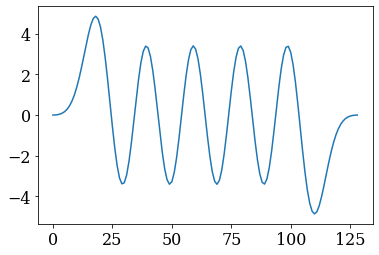

In [8]:
plt.plot(hu)
hu.shape

torch.Size([71])

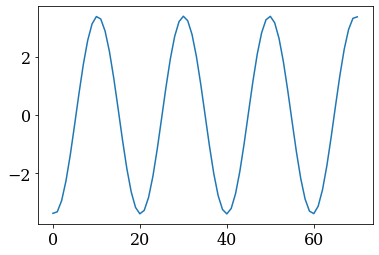

In [9]:
hu_base = conv1d(u[None], h[None, None])[0] 
# Note: [None] is a way to add a new dummy dimension
# for compatibility with the PyTorch API

plt.plot(hu_base)
hu_base.shape

This is different... because PyTorch computes centered convolutions by default! In particular,
it does not pad before `u` and starts when the kernel overlaps the first `M` elements of `u`.
Notice the different length of `hu_base`: `L - M + 1`.

 `1` as the starting point, and `L - M` being
the number of "moves" the kernel can make as it slides over the input.

torch.Size([129])

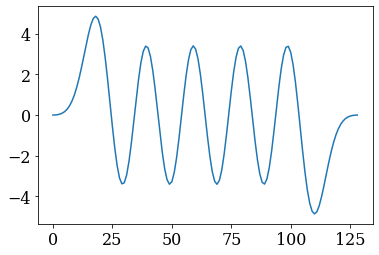

In [10]:
u_pad = pad(u, (M-1, M-1))
hu_base_padded = conv1d(u_pad[None], h[None, None])[0]   

plt.plot(hu_base_padded)
hu_base_padded.shape

In [11]:
assert torch.allclose(hu, hu_base_padded, atol=1e-5)

### The matmul view

In [12]:
def centered_toeplitz(h, L, M):
    T = torch.zeros(L - M + 1, L)

    T[0, :M] = h
    for i in range(1, L - M + 1): T[i] = torch.roll(T[i-1], 1)
    return T

T = centered_toeplitz(h, L, M)

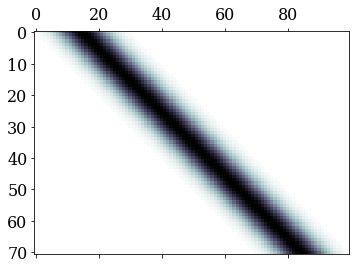

In [13]:
plt.matshow(T, cmap='bone_r')

In [14]:
hu_mat = T@u

In [15]:
# recall that 
# hu_base = conv1d(u[None], h[None, None])[0] i.e., convolution without padding
assert torch.allclose(hu_base, hu_mat, atol=1e-5)

To recover the padded version version we construct the "proper" Toeplitz matrix.

In the first row we introduce only the last element of `h`: the kernel does not start
completely overlapping with `u`, but can be thought of sliding from the "left", with an
implicit zero-padding of `u` of `M - 1` values before and `M - 1` after.

In [16]:
def full_toeplitz(h, L, M):
    T = torch.zeros(L + M - 1, L)
    for i in range(M): T[i, :i+1] = h[-i-1:]
    for i in range(M, L): T[i] = torch.roll(T[i-1], 1)
    for i in range(L, L + M - 1):
        T[i, -M+i-L+1:] = h[:-i-1+L]
    return T

T = full_toeplitz(h, L, M)

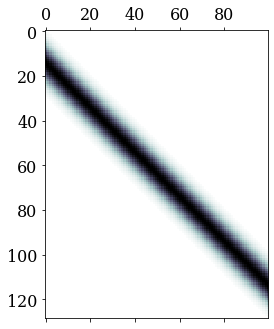

In [17]:
plt.matshow(T, cmap='bone_r')

In [18]:
hu_mat2 = T@u

In [19]:
assert torch.allclose(hu, hu_mat2, atol=1e-5)

Text(0.5, 1.0, '"Full" Toeplitz matmul')

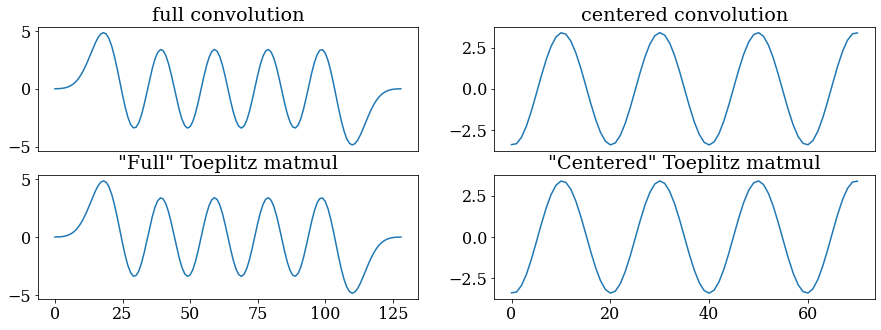

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0,0].plot(hu)
axs[0,0].set_title('full convolution')
axs[0,0].set_xticks([])

axs[0,1].plot(hu_base)
axs[0,1].set_title('centered convolution')
axs[0,1].set_xticks([])

axs[1,1].plot(hu_mat)
axs[1,1].set_title('"Centered" Toeplitz matmul')

axs[1,0].plot(hu_mat2)
axs[1,0].set_title('"Full" Toeplitz matmul')